In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

#import dask.dataframe as dd

from datetime import datetime

In [1]:
import keras 

from keras.preprocessing import sequence
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, LeakyReLU
from keras.layers import Embedding
from keras.layers import Concatenate, Flatten, Reshape, Lambda
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.utils import plot_model
from keras import backend as K

from keras.datasets import imdb

Using TensorFlow backend.


In [3]:
#K.tensorflow_backend._get_available_gpus()

Helpful links:
1. Inverse of np.log1p: https://stackoverflow.com/questions/50049891/what-is-the-inverse-of-numpys-log1p
2. Building parallel keras model: https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras
3. How to make parallel keras models: https://datascience.stackexchange.com/questions/39407/how-to-make-two-parallel-convolutional-neural-networks-in-keras
4. 2 parallel keras layers: https://stackoverflow.com/questions/51546075/two-parallel-conv2d-layers-keras
5. Setting up Conv1D and LSTM: https://stackoverflow.com/questions/51344610/how-to-setup-1d-convolution-and-lstm-in-keras
6. Take average of LSTM hidden states using Lambda: https://stackoverflow.com/questions/51479940/average-channels-of-convolutional-layer-keras
7. Preparing categorical variable for neural networks: https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
8. Tutorial for using keras for time series (no generators used): https://medium.com/@jdwittenauer/deep-learning-with-keras-structured-time-series-37a66c6aeb28


In [3]:
train = pd.read_csv("gs://123test_bucket/train.csv")

OSError: Forbidden: https://www.googleapis.com/storage/v1/b/123test_bucket/o/
174050236939-compute@developer.gserviceaccount.com does not have storage.objects.list access to 123test_bucket.

In [5]:
reading = train['meter_reading']
train['meter_reading'] = np.log1p(train['meter_reading'])

scaler1 = MinMaxScaler()
train['meter_reading'] = scaler1.fit_transform(X=np.reshape(train['meter_reading'].values, (-1, 1))).reshape(len(train),)

In [6]:
train['meter_reading'].mean()

0.2452794762030242

#### Reading Test Data

In [7]:
test = pd.read_csv("gs://123test_bucket/test.csv")

In [8]:
train.timestamp = pd.to_datetime(train.timestamp)
test.timestamp = pd.to_datetime(test.timestamp)

In [9]:
len(train), len(test)

(20216100, 41697600)

#### Reading Weather and Meta Data

In [10]:
weather_train = pd.read_csv("gs://123test_bucket/weather_train.csv")
weather_test = pd.read_csv("gs://123test_bucket/weather_test.csv")
meta = pd.read_csv("gs://123test_bucket/building_metadata.csv")

In [11]:
weather_train.timestamp = pd.to_datetime(weather_train.timestamp)
weather_test.timestamp = pd.to_datetime(weather_test.timestamp)

In [12]:
train = pd.merge(pd.merge(train, meta, on='building_id', how='left'),
                 weather_train,
                 on=['site_id', 'timestamp'],
                 how='inner')
test = pd.merge(pd.merge(test, meta, on='building_id', how='left'),
                 weather_test,
                 on=['site_id', 'timestamp'],
                 how='left')

In [55]:
train['month'] = train.timestamp.dt.month
train['dayofweek'] = train.timestamp.dt.dayofweek
train['dayofyear'] = train.timestamp.dt.dayofyear
train['hour'] = train.timestamp.dt.hour

test['month'] = test.timestamp.dt.month
test['dayofweek'] = test.timestamp.dt.dayofweek
test['dayofyear'] = test.timestamp.dt.dayofyear
test['hour'] = test.timestamp.dt.hour

In [14]:
test.loc[40525*1024: (40525*1024)+1024]

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour
41497600,41497600,1337,1,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20
41497601,41497601,1337,2,2018-12-31 20:00:00,15,Office,14744,1910.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20
41497602,41497602,1338,0,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20
41497603,41497603,1338,2,2018-12-31 20:00:00,15,Education,31415,1912.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20
41497604,41497604,1339,0,2018-12-31 20:00:00,15,Education,140488,1961.0,NaN,2.8,NaN,1.1,NaN,1017.8,140.0,5.1,12,0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41498620,41498620,144,0,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9
41498621,41498621,144,3,2017-01-18 09:00:00,1,Office,57673,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9
41498622,41498622,145,0,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9
41498623,41498623,145,3,2017-01-18 09:00:00,1,Office,14219,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,9


#### Sine of Time Components

In [56]:
np.round(np.sin(2*np.pi *(12/24)), 1)

0.0

In [57]:
train['hour'] = np.round(np.sin(2*np.pi *(train['hour']/24)), 1)
test['hour'] = np.round(np.sin(2*np.pi *(test['hour']/24)), 1)

In [58]:
min(train['month']), max(train['month'])

(1, 12)

In [59]:
np.round(np.sin(2*np.pi *((4-1)/12)), 1)

1.0

In [60]:
train['month'] = np.round(np.sin(2*np.pi *((train['month']-1)/12)), 1)
test['month'] = np.round(np.sin(2*np.pi *((test['month']-1)/12)), 1)

In [61]:
min(train['dayofweek']), max(train['dayofweek'])

(0, 6)

In [65]:
min(train['dayofyear']), max(train['dayofyear'])

(1, 366)

In [66]:
train['dayofyear'] = np.round(np.sin(2*np.pi *((train['dayofyear']-1)/366)), 1)
test['dayofyear'] = np.round(np.sin(2*np.pi *((test['dayofyear']-1)/366)), 1)

#### Assigning Weekday

Not assigning holidays since they may not be all US.

In [75]:
train['weekday'] = 0
test['weekday'] = 0
weekday_map = {0:0,
               1:0,
               2:0,
               3:0,
               4:0,
               5:1,
               6:1}

In [76]:
train['weekday'] = train['dayofweek'].map(weekday_map)
test['weekday'] = test['dayofweek'].map(weekday_map)

In [77]:
time_cols = ['hour', 'month', 'dayofweek', 'dayofyear', 'weekday']

#### Scaling Data

In [78]:
train = train.fillna(0)
test = test.fillna(0)

In [79]:
scaler2 = MinMaxScaler()
num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'square_feet', 'floor_count']
scaler2.fit(train[num_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [80]:
train[num_cols] = scaler2.transform(train[num_cols])
test[num_cols] = scaler2.transform(test[num_cols])

#### Joining Weather, Metadata with load data

In [81]:
len(train), len(test)

(20125605, 41697600)

In [82]:
train.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'month', 'dayofweek', 'hour', 'dayofyear', 'weekday'],
      dtype='object')

In [83]:
train.head(2)

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,dayofweek,hour,dayofyear,weekday
0,0,0,2016-01-01,0.0,0,Education,0.008173,2008.0,0.0,0.708279,...,0.900164,0.002907,0.975323,0.0,0.0,0.0,4,0.0,0.0,0
1,1,0,2016-01-01,0.0,0,Education,0.002786,2004.0,0.0,0.708279,...,0.900164,0.002907,0.975323,0.0,0.0,0.0,4,0.0,0.0,0


#### Encoding Categorical Variables

In [84]:
enc = OneHotEncoder(drop='first', sparse=False)
cat_cols = ['site_id', 'primary_use', 'year_built']
other_cols = ['building_id', 'meter']
enc.fit(train[cat_cols + other_cols])

OneHotEncoder(categorical_features=None, categories=None, drop='first',
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

#### Random ID selection

Using 30% of the data as validation data. If more data is needed, we should consider adding data by randomly selecting buildings.

In [85]:
ids = train['building_id'].unique()

In [86]:
# keeping 80% of the ids
len_sub = round(len(ids)*0.80)
ids_sub = np.random.choice(ids, len_sub, replace = False)

In [87]:
# 0.3 represents the percentage of data that is kept for validation
len_val = round(len(ids_sub)*0.3)

In [88]:
ids_val = np.random.choice(ids_sub, len_val, replace = False)

In [89]:
ids_train = np.setdiff1d(ids_sub,ids_val)

In [90]:
assert len(ids_val)+len(ids_train)==len(ids_sub)

#### Applying TimeseriesGenerator to the ASHRAE training data

Once difference between the example above, and our situation is that we have multiple timeseries, for each building and each meter in the building. So, we will be required to modify the code a little bit.

Below, we check how many meters exist in the dataset.

In [91]:
len(train[['building_id', 'meter']].drop_duplicates()), len(test[['building_id', 'meter']].drop_duplicates())

(2380, 2380)

The code below has been taken from this stackoverflow answer with some modifications:
https://stackoverflow.com/questions/55116638/use-keras-timeseriesgenerator-function-to-generate-squence-group-by-some-id/55118459#55118459

The modification is basically that once we subset the data for building ID, it is then subset for meter type also.

Further reading about modifying keras generator classes can be found below:
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [92]:
# num_cols = ['air_temperature', 'cloud_coverage', 'dew_temperature',
#        'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
#        'wind_speed', 'square_feet', 'floor_count']

num_cols = num_cols + time_cols

cat_names = cat_cols + other_cols

new_cat_names = list(enc.get_feature_names(cat_names))

col_names = num_cols + new_cat_names

In [93]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, new_cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = len(dt)//batch_size
        self.dt = dt[num_cols + cat_names + ['meter_reading']]
        self.num_cols = num_cols
        self.cat_names = cat_names
        self.new_cat_names = new_cat_names

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        cat_vals = enc.transform(adf[self.cat_names])
        return np.concatenate([adf[self.num_cols].values, cat_vals], axis =1), adf['meter_reading']

In [94]:
class TestDataGenerator(keras.utils.Sequence):
    def __init__(self, dt, num_cols, cat_names, new_cat_names, batch_size = 10):
        self.batch_size = batch_size
        self.len = round(len(dt)/batch_size)
        self.dt = dt[num_cols + cat_names]
        self.num_cols = num_cols
        self.cat_names = cat_names
        self.new_cat_names = new_cat_names

    def __len__(self):
        return self.len+1

    def __getitem__(self, index):
        index_start = index*self.batch_size
        index_end = index_start+self.batch_size
        adf = self.dt[index_start:index_end]
        cat_vals = enc.transform(adf[self.cat_names])
        return np.concatenate([adf[self.num_cols].values, cat_vals], axis =1)

#### Training and Validation Generators

In [95]:
# Test
batch_size = 1024#1024+512
train_gen = DataGenerator(train[train['building_id'].isin(ids_train)], 
                          num_cols=num_cols, 
                          cat_names=cat_names,
                          new_cat_names = new_cat_names,
                          batch_size=batch_size)
val_gen = DataGenerator(train[train['building_id'].isin(ids_val)],
                        num_cols=num_cols, 
                        cat_names=cat_names,
                        new_cat_names = new_cat_names,
                        batch_size=batch_size)   


In [96]:
check1 = train_gen[0]
check2 = val_gen[0]

In [97]:
check1[0].shape, check1[1].shape, len(col_names)

((1024, 1611), (1024,), 1611)

#### Loss Function - Root Mean Square

In [98]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

#### Dense NN

In [210]:
#model = Sequential()
filters = 10
ncols = len(col_names) # categorical columns
states = 20
act = 'relu'

input_shape1 = Input(shape=(ncols,))

m1 = Dense(400, activation=act)(input_shape1)
m1 = Dense(200, activation=act)(m1)
m1 = LeakyReLU(alpha=0.1)(m1)
m1 = Dropout(0.2)(m1)
m1 = Dense(1, activation='sigmoid')(m1)

model2 = Model(inputs = input_shape1, outputs = m1)
model2._make_predict_function()

In [211]:
opt = keras.optimizers.RMSprop(clipnorm=1.)

model2.compile(loss=root_mean_squared_error, optimizer=opt, metrics=['mse', 'mae', 'mape'])

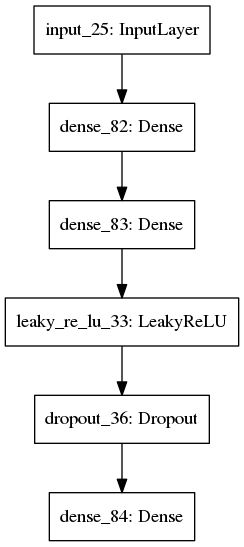

In [212]:
plot_model(model2)

In [213]:
model2.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 1611)              0         
_________________________________________________________________
dense_82 (Dense)             (None, 400)               644800    
_________________________________________________________________
dense_83 (Dense)             (None, 200)               80200     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 200)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 201       
Total params: 725,201
Trainable params: 725,201
Non-trainable params: 0
____________________________________________________

In [214]:
# Train model on dataset
epochs = 1#TODO: change it back to 5
workers = 10
model2.fit_generator(generator=train_gen,
                    validation_data=val_gen, epochs=epochs, 
                    use_multiprocessing=True, workers = workers)

Epoch 1/1
10980/10980 [==============================] - 380s 35ms/step - loss: 0.0549 - mse: 0.0033 - mae: 0.0321 - mape: 7426131.0000 - val_loss: 0.1518 - val_mse: 0.0289 - val_mae: 0.1388 - val_mape: 8347208.0000


In [215]:
# For Dense 200, epoch 1: loss=0.0881
# For Dense 200, followed by Dropout(0.2), followed by Dense 200, epoch 1: loss=0.0866
# For Dense 200, followed by Dropout(0.2), followed by Dense 200, act = relu, epoch 1: loss=0.0661
# For replaced Dense 5 (second last layer) to Dense 20, act = relu, epoch 1: loss=0.0597
# For replaced Dense 5 (second last layer) to Dense 30, act = relu, epoch 1: loss=0.0585
# For replaced Dense 5 (second last layer) to Dense 100, act = relu, epoch 1: loss=0.0564
# For replaced Dense 5 (second last layer) to Dense 200, act = relu, epoch 1: loss=0.0562
# First Dense 400, second Dense 200, act = relu, epoch 1: loss=0.0547
# First Dense 500, second Dense 400, act = relu, epoch 1: loss=0.0545


In [ ]:
val_test_gen = TestDataGenerator(train[train['building_id'].isin(ids_val)], 
                                 num_cols=num_cols, 
                                cat_names=cat_names,
                                new_cat_names = new_cat_names,
                                batch_size=batch_size)
print(len(val_test_gen))

val_test_res = model2.predict_generator(generator=val_test_gen, workers=12, use_multiprocessing=True)
val_test_res_og = pd.Series(np.expm1(scaler1.inverse_transform(val_test_res)).reshape(val_test_res.shape[0],))

x = []
for i in range(len(val_test_gen)):
    x.append(val_gen[i][1].values)

val_test_y = pd.Series(np.expm1(scaler1.inverse_transform(np.concatenate(x, axis=0).reshape(1, -1))).reshape(val_test_res.shape[0],))

print(len(val_test_y) == len(val_test_res_og))

In [44]:
print("Error: " +str({np.sqrt(np.mean(np.square(val_test_res_og - val_test_y)))}))

Error: {309981.0964942758}


#### Defining Function for Prediction - Method 1

In [58]:
test_gen = TestDataGenerator(test, num_cols=num_cols, 
                        cat_names=cat_names,
                        new_cat_names = new_cat_names,
                        batch_size=batch_size)

In [59]:
len(test_gen)

40721

In [60]:
cat_cols

['site_id', 'hour', 'dayofweek', 'month', 'primary_use', 'year_built']

In [61]:
#enc.categories_

In [62]:
#test.loc[40525*1024: (40525*1024)+1024]#.dt.month

In [63]:
result = model2.predict_generator(generator=test_gen, workers=12, use_multiprocessing=True, verbose=1)

40721/40721 [==============================] - 874s 21ms/step


In [64]:
result# = None

array([[0.12478477],
       [0.11829028],
       [0.07486442],
       ...,
       [0.2161943 ],
       [0.30534786],
       [0.0783847 ]], dtype=float32)

In [65]:
result.shape

(41697600, 1)

In [66]:
#pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],))

In [67]:
#len(pd.read_csv("gs://123test_bucket/test.csv"))

In [68]:
41697600/batch_size

40720.3125

In [69]:
result_df = pd.DataFrame({'meter_reading':pd.Series(np.expm1(scaler1.inverse_transform(result)).reshape(result.shape[0],)),
                         'row_id':test['row_id']})

In [70]:
result_df = result_df[['row_id', 'meter_reading']]

In [71]:
result_df.head(2)

,row_id,meter_reading
0,0,7.241138
1,1,6.384382


In [72]:
result_df.shape

(41697600, 2)

In [73]:
result_df.to_csv("gs://123test_bucket/result.csv", index=False)

In [61]:
check = pd.read_csv("result.csv")
check.shape

(41697600, 2)

In [68]:
result_df[result_df.meter_reading.isnull()]

,row_id,meter_reading


In [74]:
sample = pd.read_csv("gs://123test_bucket/sample_submission.csv")

In [76]:
sample['meter_reading'] = result_df['meter_reading']

In [77]:
sample = sample.fillna(0)

In [78]:
sample.to_csv("result_sample.csv", index=False)

In [79]:
# serialize model to JSON
model_json = model2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
